In [1]:
import matplotlib.pyplot as plt

import analysis
import experiment
from evaluation.analysis import p99_latency

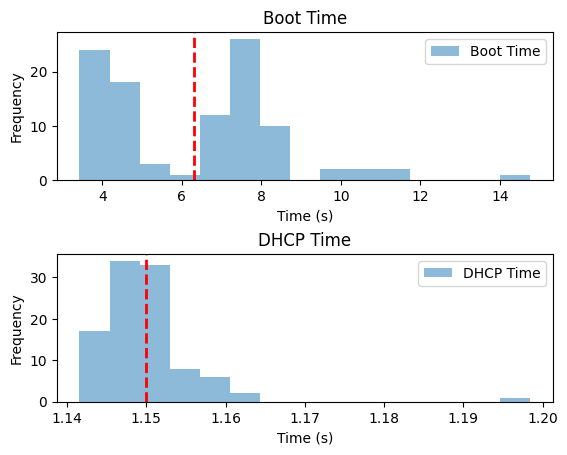

In [21]:
# 100 restarts
e = experiment.load_experiment('7a800416-ea37-4982-b430-380e3f99ac81')
boot_times = []
dhcp_time = []
for m in e.control_data['measurements']:
    boot_times.append(m['boot_packet_timestamp'] - m['start_timestamp'])
    x = m['serial_log'].rfind('DHCP Ready')
    dhcp_time.append(float(m['serial_log'][x-55:x].split(']')[0][1:].strip()))

boot_times = [bt - dt for bt, dt in zip(boot_times, dhcp_time)]

sum(boot_times) / len(boot_times)
sum(dhcp_time) / len(dhcp_time)

# Create two separate plots
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1)

boot_time_mean = sum(boot_times)/len(boot_times)
dhcp_time_mean = sum(dhcp_time)/len(dhcp_time)
# Plot the histograms in each subplot
ax1.hist(boot_times, bins=15, alpha=0.5, label='Boot Time')

ax1.legend(loc='upper right')
ax1.axvline(sum(boot_times)/len(boot_times), color='red', linestyle='dashed', linewidth=2, label='Mean')
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Frequency')
ax1.set_title('Boot Time')

ax2.hist(dhcp_time, bins=15, alpha=0.5, label='DHCP Time')
ax2.legend(loc='upper right')
ax2.axvline(sum(dhcp_time)/len(dhcp_time), color='red', linestyle='dashed', linewidth=2, label='Mean')

ax2.set_xlabel('Time (s)')
ax2.set_ylabel('Frequency')
ax2.set_title('DHCP Time')

# Adjust spacing between subplots
plt.subplots_adjust(hspace=0.5)
plt.savefig(f'boot_time_dhcp_time.pdf')

# Display the plots
plt.show()

In [45]:
def analysis_test_bench(id: str):
    e = experiment.load_experiment(id)
    sample_rate = int(e.control_data['configuration']['sample_rate'])
    rcv_measurement = e.sink_data['measurements'][0]
    src_measurement = e.source_data['measurements'][0]

    recv_timestamps = rcv_measurement['tuples_received_timestamps']
    send_timestamps = src_measurement['tuples_sent_timestamps']

    time_offset = src_measurement['start_unix_timestamp'] - rcv_measurement['start_unix_timestamp']

    rcv_offset = rcv_measurement['start_timestamp']
    src_offset = src_measurement['start_timestamp']
    e2e = recv_timestamps[-1] - send_timestamps[0]

    recv_timestamps = [ts - rcv_offset for ts in recv_timestamps]
    send_timestamps = [ts - src_offset for ts in send_timestamps]

    group_size = 400

    def slice_around(arr, pos):
        low = max(0 , pos - group_size // 2)
        high = min(len(arr) , pos + group_size // 2)
        print(low, high)
        return arr[low:high]

    tuple_latencies = [recv_timestamps[i] - send_timestamps[i] for i in range(len(send_timestamps))]
    average_latencies = [
        (sum(slice_around(tuple_latencies, x)) / len(slice_around(tuple_latencies, x)), send_timestamps[x]) for x in
        range(0, len(tuple_latencies), group_size)]

    p99_latencies = [(p99_latency(slice_around(tuple_latencies, x)), send_timestamps[x]) for x in
                     range(0, len(tuple_latencies), group_size)]

    throughput = []
    interval_in_s = 5
    current = recv_timestamps[0]
    current_counter = 0
    for recv in recv_timestamps:
        if recv > current + interval_in_s:
            throughput.append((current_counter / interval_in_s, current))
            current_counter = 1
            current = recv
        else:
            current_counter += 1

    throughput.append((current_counter / (recv_timestamps[-1] - current), current))

    return sample_rate, throughput, average_latencies, p99_latencies

0 200
0 200
200 600
200 600
600 1000
600 1000
1000 1400
1000 1400
1400 1800
1400 1800
1800 2200
1800 2200
2200 2600
2200 2600
2600 3000
2600 3000
3000 3400
3000 3400
3400 3800
3400 3800
3800 4200
3800 4200
4200 4600
4200 4600
4600 5000
4600 5000
5000 5400
5000 5400
5400 5800
5400 5800
5800 6200
5800 6200
6200 6600
6200 6600
6600 7000
6600 7000
7000 7400
7000 7400
7400 7800
7400 7800
7800 8200
7800 8200
8200 8600
8200 8600
8600 9000
8600 9000
9000 9400
9000 9400
9400 9800
9400 9800
9800 10200
9800 10200
10200 10600
10200 10600
10600 11000
10600 11000
11000 11400
11000 11400
11400 11800
11400 11800
11800 12200
11800 12200
12200 12600
12200 12600
12600 13000
12600 13000
13000 13400
13000 13400
13400 13800
13400 13800
13800 14200
13800 14200
14200 14600
14200 14600
14600 15000
14600 15000
15000 15400
15000 15400
15400 15800
15400 15800
15800 16200
15800 16200
16200 16600
16200 16600
16600 17000
16600 17000
17000 17400
17000 17400
17400 17800
17400 17800
17800 18200
17800 18200
18200 18600


[(314.0, 0.009690678911283612),
 (299.2, 5.010127173969522),
 (316.4, 10.013087840983644),
 (299.6, 15.013559466926381),
 (299.4, 20.01543468097225),
 (295.0, 25.018654668936506),
 (315.4, 30.0188751288224),
 (284.8, 35.02044827095233),
 (313.8, 40.02233613585122),
 (288.6, 45.02449592389166),
 (316.0, 50.02479640301317),
 (297.4, 55.02665685582906),
 (296.8, 60.0274193410296),
 (320.83034477203233, 65.0302077550441)]

In [46]:
low_throughput = throughput

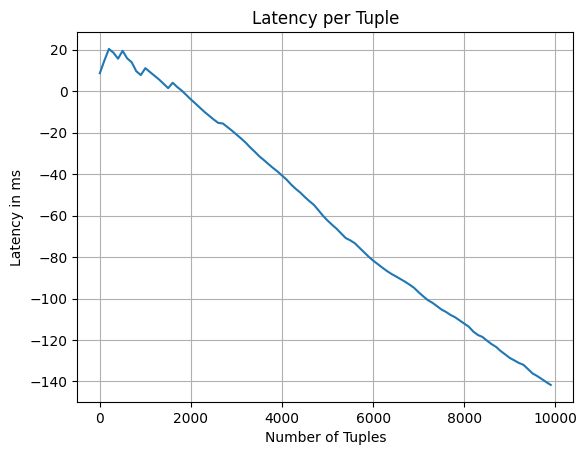

In [29]:
length = 100
plt.plot([tuple_number * sample_rate for tuple_number in range(length)], [lt * 1000 for lt in tuple_latencies[:length]])
plt.title(f'Latency per Tuple')
# plt.yscale('log')
plt.ylabel('Latency in ms')
plt.xlabel('Number of Tuples')
plt.grid()
plt.savefig(f'first_tuples_latency.pdf')
plt.show()

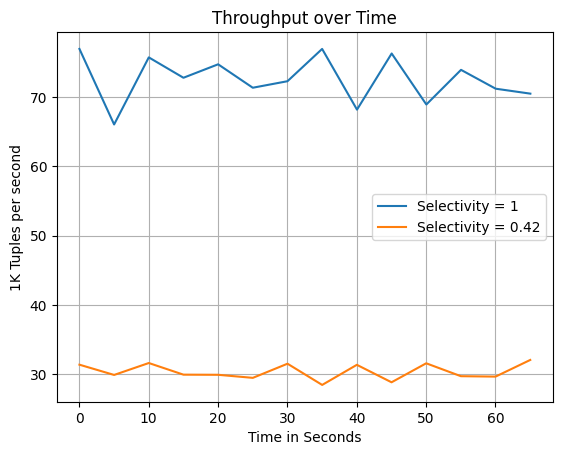

In [39]:
x = [p[1] for p in low_throughput]
x1 = [p[1] for p in throughput]
y = [p[0] * sample_rate / 1000 for p in low_throughput]
y1 = [p[0] * sample_rate / 1000 for p in throughput]

plt.plot(x, y)
plt.plot(x1, y1)
plt.title('Throughput over Time')
# plt.yscale('log')
plt.ylabel('1K Tuples per second')
plt.xlabel('Time in Seconds')
plt.grid()
plt.legend(['Selectivity = 1', 'Selectivity = 0.42'])
plt.savefig(f'unikraft_throughput-selectivity.pdf')
plt.show()

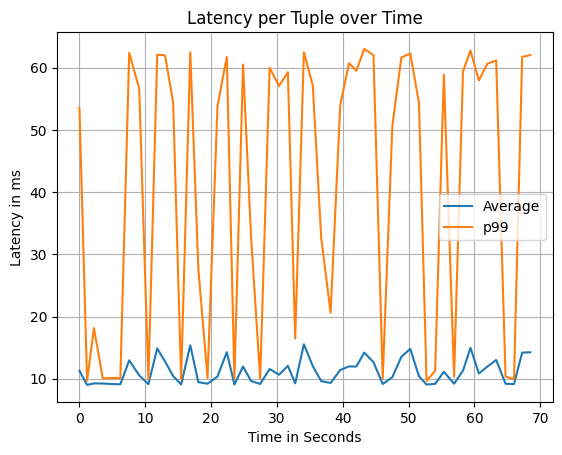

In [16]:
x = [p[1] for p in average_latencies]
y = [p[0] * 1000 for p in average_latencies]
x1 = [p[1] for p in p99_latencies]
y1 = [p[0] * 1000 for p in p99_latencies]

plt.plot(x, y)
plt.plot(x1, y1)
plt.title('Latency per Tuple over Time')
# plt.yscale('log')
plt.ylabel('Latency in ms')
plt.xlabel('Time in Seconds')
plt.grid()
plt.legend(["Average", "p99"])
plt.savefig(f'unikraft_average_latencies.pdf')
plt.show()


In [47]:
unikraft_throughput = throughput
unikraft_average_latencies = average_latencies

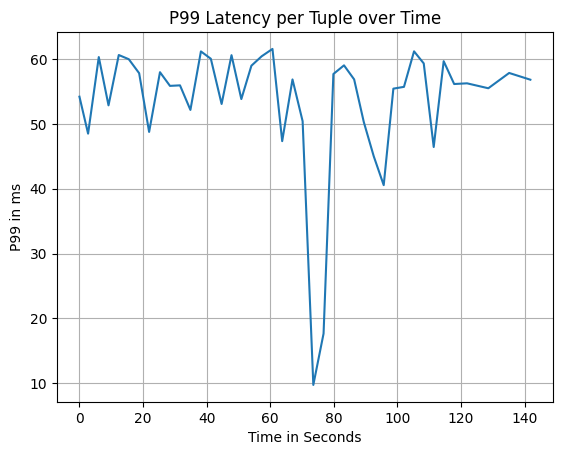

In [205]:
x = [p[1] for p in p99_latencies]
y = [p[0] * 1000 for p in p99_latencies]

plt.plot(x, y)
plt.title('P99 Latency per Tuple over Time')
# plt.yscale('log')
plt.ylabel('P99 in ms')
plt.xlabel('Time in Seconds')
plt.grid()
plt.show()

In [206]:
send_latencies = analysis.get_send_latency(experiment)
plt.plot(send_latencies)
plt.title('Send latency (log scale)')
plt.yscale('log')
plt.ylabel('send latency (ms)')
plt.xlabel('number of tuples')
plt.grid()
plt.savefig(f'{id}/send.pdf')
plt.show()

AttributeError: module 'experiment' has no attribute 'source_data'

In [207]:
results = []
with open("result_e2-micro-fail.csv") as f:
    next(f)
    batch_size = 100
    i = 0
    for l in f:
        if i % batch_size == 0:
            t1, t2, t3, t4, _ = l.split(',', 4)
            results.append((int(t1), int(t2), int(t3), int(t4)))
        i += 1

start_timestamp = 1676806909300
start_offset = results[0][0]

results = [((t1 - start_offset) + start_timestamp, t2, t3, t4) for t1, t2, t3, t4 in results]
e2e = [t4 - t1 for t1, t2, t3, t4 in results]
timestamps = [t1 - start_timestamp for t1, t2, t3, t4 in results]

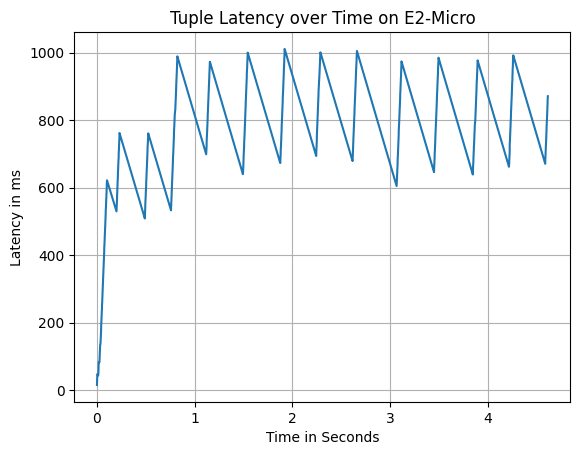

In [208]:
y = e2e[:1000]
x = [t / 1000 for t in timestamps[:1000]]

plt.plot(x, y)
plt.title('Tuple Latency over Time on E2-Micro')
plt.ylabel('Latency in ms')
plt.xlabel('Time in Seconds')
plt.grid()
plt.savefig(f'nes_micro_fail_latencies_small.pdf')
plt.show()

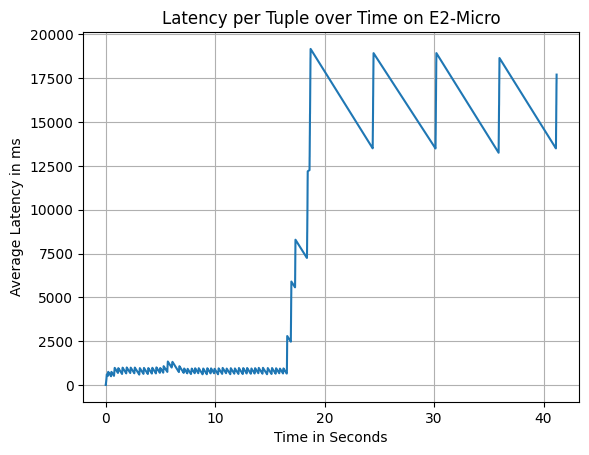

In [209]:
y = e2e[:4000]
x = [t / 1000 for t in timestamps[:4000]]

plt.plot(x, y)
plt.title('Latency per Tuple over Time on E2-Micro')
plt.ylabel('Average Latency in ms')
plt.xlabel('Time in Seconds')
plt.grid()
plt.savefig(f'nes_micro_fail_latencies_large.pdf')
plt.show()

In [50]:
# high 2023-03-02 21:15:22.531067: 227745
# 1677791722.0 to 1677791755.0
def analysis(start_timestamp, start_offset, csv_file_name):
    results = []
    with open(csv_file_name) as f:
        next(f)
        for l in f:
            t1, t2, t3, t4, _ = l.split(',', 4)
            results.append((int(t1), int(t2), int(t3), int(t4)))

    results = [((t1 - start_offset) + start_timestamp, t2, t3, t4) for t1, t2, t3, t4 in results]
    recv_timestamps_in_seconds = [(t4 - start_timestamp) / 1000  for t1, t2, t3, t4 in results]
    latency_to_worker_send = [t3 - t1 for t1, t2, t3, t4 in results]
    timestamps_in_ms = [t1 - start_timestamp for t1, t2, t3, t4 in results]

    throughput = []
    interval_in_s = 2
    current = recv_timestamps_in_seconds[0]
    current_counter = 0
    total = 0
    for recv in recv_timestamps_in_seconds:
        total += 1
        if recv > current + interval_in_s:
            throughput.append((current_counter / interval_in_s, current))
            current_counter = 1
            current = recv
        else:
            current_counter += 1

    throughput.append((current_counter / (recv_timestamps_in_seconds[-1] - current), current))

    group_size = 50000
    average_latencies = [
        (sum(latency_to_worker_send[x:x + group_size]) / len(latency_to_worker_send[x:x + group_size]), timestamps_in_ms[x]) for x
        in
        range(0, len(latency_to_worker_send), group_size)]

    p99_latencies = [(p99_latency(latency_to_worker_send[x:x + group_size]), timestamps_in_ms[x]) for x in
                     range(0, len(latency_to_worker_send), group_size)]

    return throughput, average_latencies, p99_latencies

In [51]:
throughput_high, average_latencies_high, p99_latencies_high = analysis(1677791722067, 227745, 'result_100k_high_2.csv')
average_latencies_high[0] = (32000, 0)

In [52]:
throughput_low, average_latencies_low, p99_latencies_low = analysis(1677792722111, 215203, 'result_100k_low_2.csv')
average_latencies_high[0] = average_latencies_low[0]

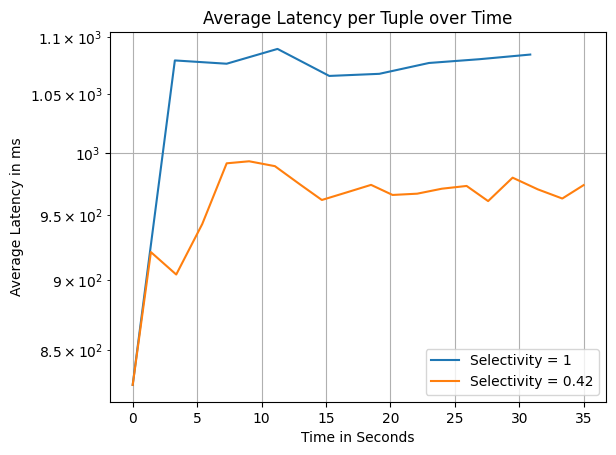

In [55]:
x = [p[1] / 1000 for p in average_latencies_high]
x1 = [p[1] / 1000 for p in average_latencies_low]
y = [p[0] for p in average_latencies_high]
y1 = [p[0] for p in average_latencies_low]

plt.plot(x, y)
plt.plot(x1, y1)
plt.title('Average Latency per Tuple over Time')
plt.yscale('log')
plt.ylabel('Average Latency in ms')
plt.xlabel('Time in Seconds')
plt.legend(['Selectivity = 1', 'Selectivity = 0.42'])
plt.grid()
plt.savefig("nes_per_tuple_latencies.pdf")
plt.show()

In [31]:
throughput = []
interval_in_s = 5
current = recv_timestamps_in_seconds[0]
current_counter = 0
total = 0
for recv in recv_timestamps_in_seconds:
    total += 1
    if recv > current + interval_in_s:
        throughput.append((current_counter / interval_in_s, current))
        current_counter = 1
        current = recv
    else:
        current_counter += 1

throughput.append((current_counter / (recv_timestamps_in_seconds[-1] - current), current))
throughput

[(14816.0, -0.702),
 (14580.4, 4.299),
 (14313.2, 9.3),
 (14388.2, 14.301),
 (14330.2, 19.302),
 (13932.097279075371, 24.303)]

In [27]:
#throughput_low = throughput

In [32]:
throughput_high = throughput

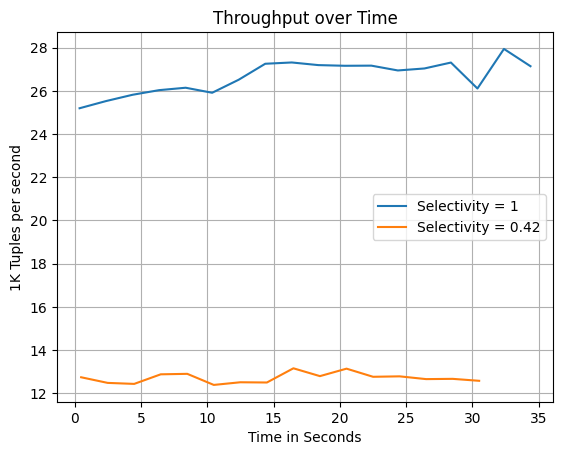

In [54]:
x = [p[1] for p in throughput_low[:-1]]
x2 = [p[1] for p in throughput_high[:-1]]
y = [p[0] / 1000 for p in throughput_low[:-1]]
y2 = [p[0] / 1000 for p in throughput_high[:-1]]
# x1 = [p[1] for p in unikraft_throughput]
# y1 = [p[0] / 10 for p in unikraft_throughput]

plt.plot(x, y)
# plt.plot(x1, y1)
plt.plot(x2, y2)
plt.title('Throughput over Time')
# plt.yscale('log')
plt.ylabel('1K Tuples per second')
plt.xlabel('Time in Seconds')
plt.legend(['Selectivity = 1', 'Selectivity = 0.42'])
plt.grid()
plt.savefig("nes_throughput.pdf")
plt.show()

In [215]:
results = []
with open("result_e2-standard-2-3.csv") as f:
    next(f)
    batch_size = 100
    i = 0
    for l in f:
        if i % batch_size == 0:
            t1, t2, t3, t4, _ = l.split(',', 4)
            results.append((int(t1), int(t2), int(t3), int(t4)))
        i += 1

start_timestamp = 1676820452692
start_offset = 1952000

results = [((t1 - start_offset) + start_timestamp, t2, t3, t4) for t1, t2, t3, t4 in results]
recv_timestamps = [(t4 - start_timestamp) for t1, t2, t3, t4 in results]
e2e = [t4 - t1 for t1, t2, t3, t4 in results]
latency_to_worker_send = [t3 - t1 for t1, t2, t3, t4 in results]
timestamps = [t1 - start_timestamp for t1, t2, t3, t4 in results]

In [216]:
group_size = 200
average_latencies = [
    (sum(e2e[x:x + group_size]) / len(e2e[x:x + group_size]), timestamps[x]) for x
    in
    range(0, len(e2e), group_size)]

p99_latencies = [(p99_latency(e2e[x:x + group_size]), timestamps[x]) for x in
                 range(0, len(e2e), group_size)]

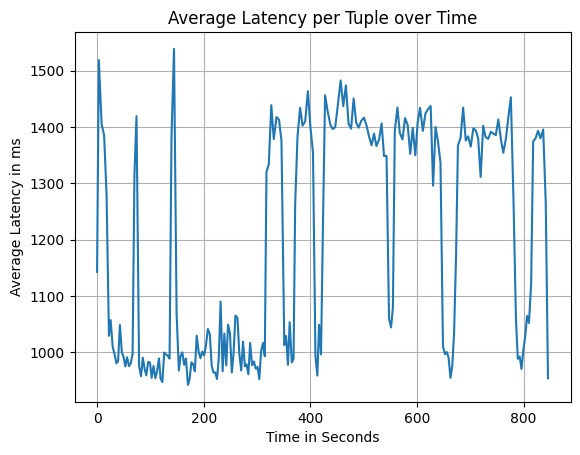

In [217]:
x = [p[1] / 1000 for p in average_latencies]
y = [p[0] for p in average_latencies]

plt.plot(x, y)
plt.title('Average Latency per Tuple over Time')
# plt.yscale('log')
plt.ylabel('Average Latency in ms')
plt.xlabel('Time in Seconds')
plt.grid()
plt.show()